In [1]:
%run -i "loaddata.py"
plt.rcParams["font.size"] = 13
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
import xgboost as xgb
save = False

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


In [2]:
# Collect all data into 1 array
keys = tuple(data_dict.keys())[::2]

data = []
for key in keys:
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]) and (vec[:][3:]!=0).any():
            data.append(vec)
data = np.array(data)
print(data.shape)
features = data_dict[ list(data_dict.keys())[1] ]

(1568, 28)


# All time series in a single plot

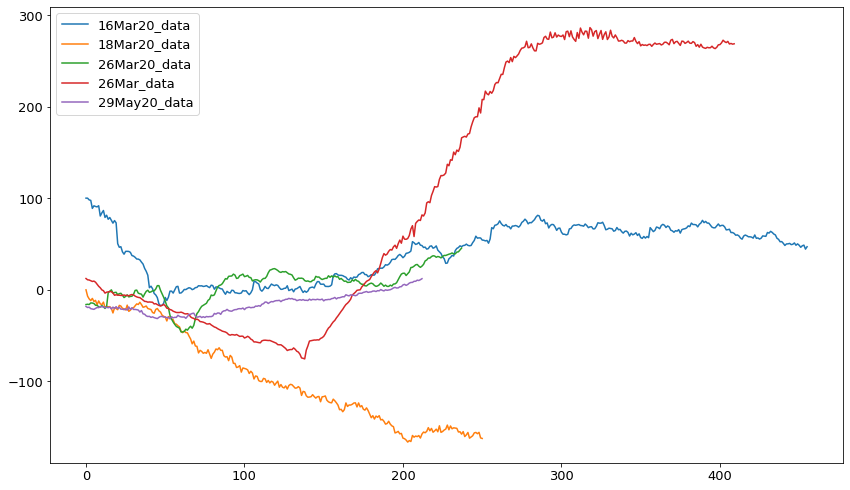

In [3]:
lengths = [len(data_dict[keys[i]]) for i in range(len(keys))]

plt.figure(figsize=(12,7))
for key in keys:
    plot_data = data_dict[key][:,1]
    plot_data = plot_data[np.isnan(plot_data) != True]
    plt.plot(plot_data, label=key)
plt.legend()
plt.tight_layout()
plt.show()

# sklearn time
## XGBoost

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[:,3:], data[:,1], test_size=0.25)

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

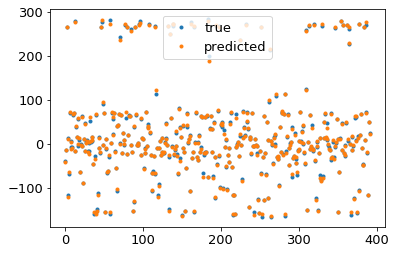

RMS = 2.841


In [5]:
plt.figure()
plt.plot(y_test, '.',label="true")
plt.plot(y_pred, '.', label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### New Split Shit

In [6]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

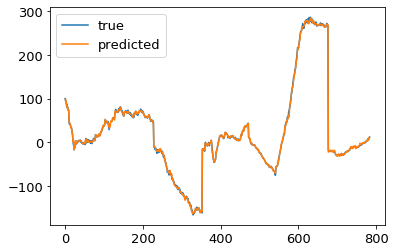

RMS = 2.654


In [7]:
plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Predict 1 timeseries

In [71]:
# Clean and put into data_sort
data_sort = []
for key in keys:
    pre_data = []
    for i in range( len(data_dict[key]) ):
        if ( (data_dict[key][i,3:] != 0.).all() ) & ( (np.isnan(data_dict[key][i, :])!=True).all() ):
            pre_data.append( list(data_dict[key][i,:]) )
    data_sort.append(np.array(pre_data))
print("Shapes of different timeseries:",[i.shape for i in data_sort])

def test_1_timeseries( test_index , scaler=False):
    X_train = np.empty(( 0, data_sort[0].shape[1]-3))
    y_train = np.array([])
    for i in range(len(data_sort)):
        if i!=test_index:
            if scaler:
                scaler = StandardScaler()
                data_scaled = scaler.fit_transform(data_sort[i])
            else:
                data_scaled = data_sort[i]
            X_train = np.append(X_train, data_scaled[:,3:], axis=0)
            y_train = np.append(y_train, data_scaled[:,1])
    if scaler:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_sort[test_index])
    else: 
        data_scaled = data_sort[test_index]
    X_test = data_scaled[:,3:]
    y_test = data_scaled[:,1]
    return X_train, X_test, y_train, y_test

Shapes of different timeseries: [(456, 28), (247, 28), (238, 28), (407, 28), (211, 28)]


(1348, 25) (211, 25) (1348,) (211,)


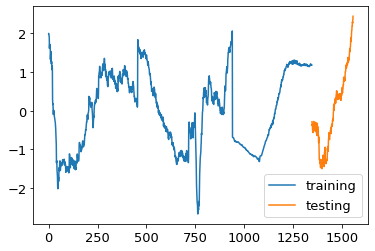

In [72]:
X_train, X_test, y_train, y_test = test_1_timeseries(4, scaler=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

### XGboost

In [75]:
# Fit
mlp = xgb.XGBRegressor()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

In [82]:
# Create a model with no hyperparameters
clf_xgb = xgb.XGBRegressor(random_state = 1, n_jobs=4)

# Parameters to search
parameters_RandomSearch = {
    "n_estimators": st.randint(1,10),
    "max_depth": st.randint(1,10),
    "learning_rate": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=1,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.2s


Random Search: 	Best parameters:  {'learning_rate': 0.38786064406417176, 'max_depth': 1, 'n_estimators': 7} , Best scores: -0.7751


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.9s finished


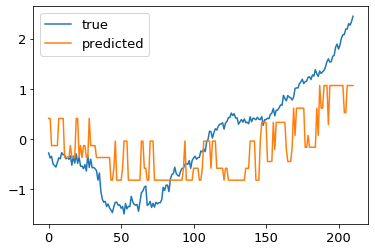

RMS = 0.762


In [83]:
y_pred = RandomSearch.predict(X_test)

plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Bayesian Optimization

In [84]:
from bayes_opt import BayesianOptimization
def xgboost_CrossValidation(num_round, eta, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=42, 
                                  num_round=num_round,
                                  eta=eta,
                                  max_depth=max_depth)
    
    cval = cross_val_score(estimator, data, targets, cv=5)
    
    return cval.mean()

def optimize_xgboost(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(num_round, eta, max_depth, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return xgboost_CrossValidation(max_depth=int(max_depth), 
                                       num_round=int(num_round),
                                       eta=eta,
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [85]:
parameters_BayesianOptimization = {"max_depth": (1, 10), 
                                   "num_round": (1, 15),
                                   "eta": (0,1)
                                  }

BayesianOptimization = optimize_xgboost(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=200)
print(BayesianOptimization.max)

|   iter    |  target   |    eta    | max_depth | num_round |
-------------------------------------------------------------
|  1        | -0.9586   |  0.3745   |  9.556    |  11.25    |
|  2        | -1.76     |  0.5987   |  2.404    |  3.184    |
|  3        | -1.085    |  0.05808  |  8.796    |  9.416    |
|  4        | -0.6392   |  0.7081   |  1.185    |  14.58    |
|  5        | -1.202    |  0.0      |  5.527    |  15.0     |
|  6        | -0.9589   |  1.0      |  10.0     |  1.0      |
|  7        | -0.9565   |  1.0      |  1.0      |  10.66    |
|  8        | -1.202    |  0.0      |  1.0      |  15.0     |
|  9        | -0.9589   |  1.0      |  10.0     |  5.179    |
|  10       | -0.9589   |  1.0      |  10.0     |  15.0     |
|  11       | -1.089    |  1.0      |  4.755    |  11.23    |
|  12       | -1.202    |  0.0      |  6.422    |  1.0      |
|  13       | -2.949    |  1.0      |  2.651    |  13.34    |
|  14       | -0.8702   |  0.4769   |  8.185    |  10.92    |
|  15   

|  81       | -0.9565   |  1.0      |  1.0      |  2.223    |
|  82       | -1.202    |  0.0      |  2.293    |  5.038    |
|  83       | -0.8595   |  1.0      |  5.456    |  1.0      |
|  84       | -0.7307   |  0.009603 |  9.925    |  9.77     |
|  85       | -1.057    |  1.0      |  9.097    |  1.992    |
|  86       | -1.202    |  0.0      |  10.0     |  5.928    |
|  87       | -2.949    |  1.0      |  2.025    |  15.0     |
|  88       | -1.202    |  0.0      |  3.285    |  11.34    |
|  89       | -1.122    |  0.07     |  4.214    |  14.7     |
|  90       | -1.202    |  0.0      |  6.938    |  6.323    |
|  91       | -1.004    |  1.0      |  6.83     |  7.816    |
|  92       | -1.089    |  1.0      |  4.32     |  2.99     |
|  93       | -0.8595   |  1.0      |  5.206    |  5.101    |
|  94       | -1.202    |  0.0      |  1.748    |  12.44    |
|  95       | -0.9972   |  0.9954   |  8.817    |  10.14    |
|  96       | -1.202    |  0.0      |  3.408    |  2.016    |
|  97   

|  162      | -0.8595   |  1.0      |  5.66     |  7.364    |
|  163      | -1.202    |  0.0      |  5.513    |  6.036    |
|  164      | -2.517    |  0.9854   |  2.087    |  5.655    |
|  165      | -0.7405   |  0.8355   |  1.035    |  5.202    |
|  166      | -1.202    |  0.0      |  7.587    |  5.267    |
|  167      | -1.202    |  0.0      |  3.855    |  3.168    |
|  168      | -0.8596   |  0.9918   |  7.393    |  6.474    |
|  169      | -1.071    |  0.03692  |  8.867    |  10.58    |
|  170      | -1.202    |  0.0      |  3.963    |  9.439    |
|  171      | -0.8595   |  1.0      |  5.634    |  15.0     |
|  172      | -1.004    |  1.0      |  6.132    |  3.027    |
|  173      | -0.3468   |  0.1101   |  1.365    |  13.09    |
|  174      | -0.9565   |  1.0      |  1.764    |  4.425    |
|  175      | -0.9528   |  0.9979   |  7.654    |  4.329    |
|  176      | -0.8746   |  0.02563  |  9.093    |  12.5     |
|  177      | -1.202    |  0.0      |  1.974    |  8.862    |
|  178  

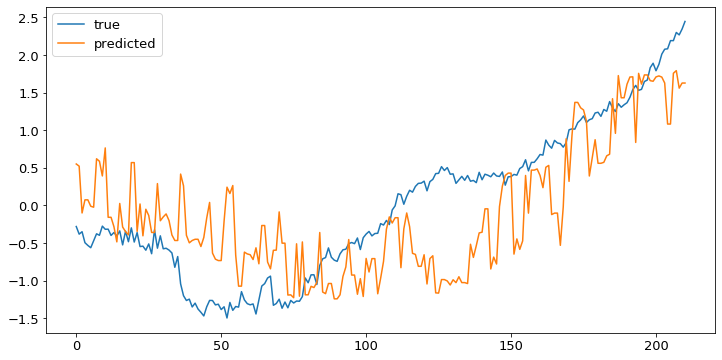

RMS = 0.731


In [86]:
model = xgb.XGBRegressor(eta = BayesianOptimization.max["params"]["eta"],
                          max_depth =int(BayesianOptimization.max["params"]["max_depth"]),
                          num_round = int(BayesianOptimization.max["params"]["num_round"]), 
                          random_state=42)

model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)#+155

# evaluate predictions
plt.figure(figsize=(12,6))
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## NN

In [87]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [88]:
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


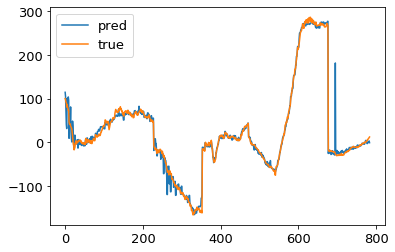

In [89]:
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV random search

In [90]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=5),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=0,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.9s finished


In [91]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (5, 1, 1), 'learning_rate_init': 0.31542835092418386} , Best scores: -85.4656


101.009592915269


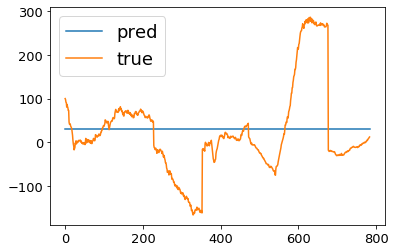

In [92]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
print(rms)
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend(fontsize=(18))
plt.show()

### Predict one timeseries

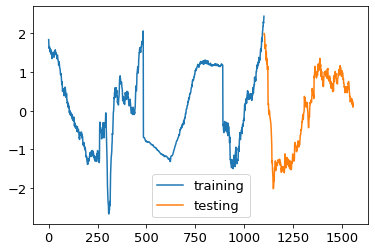

In [124]:
X_train, X_test, y_train, y_test = test_1_timeseries(0, scaler=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [125]:
# Fit
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

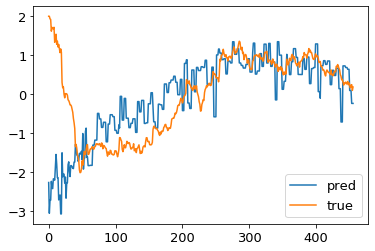

In [126]:
# Plotting
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV

In [133]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=0, learning_rate = 'adaptive', solver='adam', early_stopping=True)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=10),
    "learning_rate_init": st.uniform(),
    "max_iter": st.randint(100,1000)
}

# Number of search rounds
n_iter_search = 50

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=0,
                                  verbose = 1, 
                                  n_jobs = -1)

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.0s finished


In [134]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (70, 68, 44, 41), 'learning_rate_init': 0.038425426472734725, 'max_iter': 303} , Best scores: -0.0971


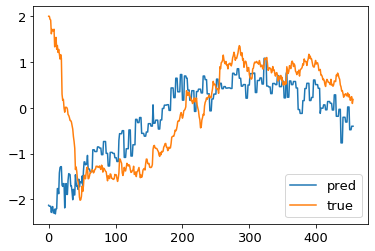

In [135]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()